# Figures

This notebook prepares figures for documenting the package.

## Initialization

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Error Estimation Models

In [174]:
def error_model_plot(label=None,var='sky',fit='snr',flux=[100.,100.],x0=[1.,1.5],sigma=[0.25,0.5],sky=100):
    # Build the source models.
    x = np.linspace(0.,3.,100)
    xx = np.vstack([x,x]).T
    sig = np.array(sigma)
    root2pi = np.sqrt(2*np.pi)
    y = (np.exp(-(xx-x0)**2/(2*sig**2))*flux/(root2pi*sig)).T
    # Plot the source models.
    plt.plot(x,y[0]+sky,'b-')
    plt.plot(x,y[1]+sky,'r--')
    # Set the vertical plot range.
    ymin = sky - 2.5*np.sqrt(sky)
    ymax = y[0]+y[1]+sky
    ymax = np.max(ymax + 1.5*np.sqrt(ymax))
    plt.ylim((ymin,ymax))
    # Draw the variance band.
    if var == 'sky':
        y_var = np.zeros_like(x) + sky
    elif var == 'iso':
        y_var = y[0]+sky
    elif var == 'grp':
        y_var = y[0]+y[1]+sky
    y_lo = y_var - np.sqrt(y_var)
    y_hi = y_var + np.sqrt(y_var)
    plt.fill_between(x,y_lo,y_hi,color='green',alpha=0.25)
    # Show fit models as vertical and horizontal double-headed arrows.
    x_arrow = x0
    y_arrow = sky + flux/(root2pi*sig)
    dx = 0.30
    dy = 35.
    if fit in ('snr','iso','grp'):
        plt.annotate('',xy=(x_arrow[0],y_arrow[0]-dy),xytext=(x_arrow[0],y_arrow[0]+dy),
            xycoords='data',textcoords='data',arrowprops={'arrowstyle':'<->','color':'black'})
    if fit in ('iso','grp'):
        plt.annotate('',xy=(x_arrow[0]-dx,y_arrow[0]),xytext=(x_arrow[0]+dx,y_arrow[0]),
            xycoords='data',textcoords='data',arrowprops={'arrowstyle':'<->','color':'black'})
    if fit in ('grp'):
        plt.annotate('',xy=(x_arrow[1],y_arrow[1]-dy),xytext=(x_arrow[1],y_arrow[1]+dy),
            xycoords='data',textcoords='data',arrowprops={'arrowstyle':'<->','color':'black'})
        plt.annotate('',xy=(x_arrow[1]-dx,y_arrow[1]),xytext=(x_arrow[1]+dx,y_arrow[1]),
            xycoords='data',textcoords='data',arrowprops={'arrowstyle':'<->','color':'black'})
    # Add optional figure label.
    if label:
        plt.annotate(label,xy=(0.95,0.95),xytext=(0.95,0.95),
            xycoords='axes fraction',textcoords='axes fraction',
            horizontalalignment='right',verticalalignment='top',fontsize='x-large')
    # Hide axis labels.
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

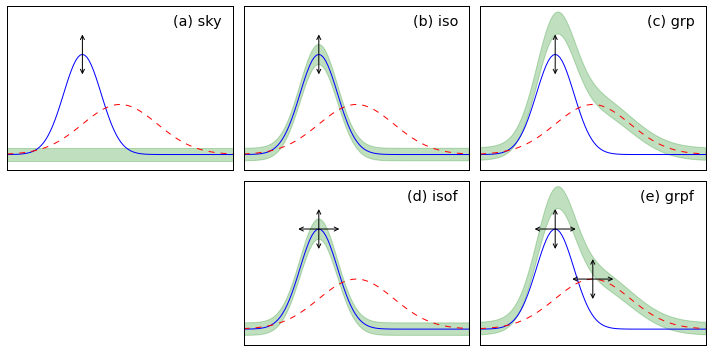

In [175]:
def error_models(name):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(2,3,1)
    error_model_plot(label='(a) sky',var='sky',fit='snr')
    plt.subplot(2,3,2)
    error_model_plot(label='(b) iso',var='iso',fit='snr')
    plt.subplot(2,3,3)
    error_model_plot(label='(c) grp',var='grp',fit='snr')
    plt.subplot(2,3,5)
    error_model_plot(label='(d) isof',var='iso',fit='iso')
    plt.subplot(2,3,6)
    error_model_plot(label='(e) grpf',var='grp',fit='grp')
    fig.tight_layout()
    if name:
        fig.savefig(name+'.pdf')
        fig.savefig(name+'.png')
error_models('output/error_models')

## Blending Contamination and Systematics

In [5]:
def blending_plot(alpha=0.5,flux=[100.,140.,10.],x0=[1.2,2.2,0.3],sigma=[0.4,0.25,0.1],save=None):
    # Build the source models.
    nsrc = len(flux)
    x = np.linspace(0.,3.,200)
    xx = np.vstack([x]*nsrc).T
    sig = np.array(sigma)
    root2pi = np.sqrt(2*np.pi)
    y = (np.exp(-(xx-x0)**2/(2*sig**2))*flux/(root2pi*sig)).T
    # Calculate the total signal.
    ytot = np.sum(y,axis=0)
    # Sort sources by decreasing flux.
    order = np.argsort(flux)[::-1]
    # Calculate the overlap matrix.
    matrix = np.einsum('ip,jp->ijp',y,y)/ytot
    overlap = np.sum(matrix,axis=1) - y**2/ytot
    ##overlap2 = (ytot[np.newaxis,:]-y)*y/ytot[np.newaxis,:]
    ##assert np.allclose(overlap,overlap2)
    purity = 1.-np.sum(overlap*y,axis=1)/np.sum(y**2,axis=1)
    purity2 = np.sum(y*y,axis=1)/np.sum(y*ytot[np.newaxis,:],axis=1)
    print 'purities:'
    print np.vstack([purity[order],purity2[order]])
    #
    fig = plt.figure(figsize=(6,4))
    #
    plt.subplot(1,1,1)
    plt.plot(x,ytot,color='black')
    colors = ('r','b','g')
    ytot2 = np.zeros_like(ytot)
    for i,src1 in enumerate(order):
        plt.plot(x,y[src1],colors[i])
        y2 = np.copy(y[src1])
        for j,src2 in enumerate(order):
            if i < j:
                plt.fill_between(x,matrix[src1,src2],facecolor='0.9',edgecolor='0.8')
            y2 += alpha*matrix[src1,src2]*np.sign(j-i)
        plt.fill_between(x,overlap[src1],y[src1],facecolor=colors[i],edgecolor='',alpha=0.1)
        plt.plot(x,y2,colors[i]+'--')
    plt.ylim(0,None)
    #
    # Hide axis labels.
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    fig.tight_layout()
    if save:
        fig.savefig(save)

purities:
[[ 0.95816932  0.9495006   0.78887296]
 [ 0.94644317  0.84024683  0.75949159]]


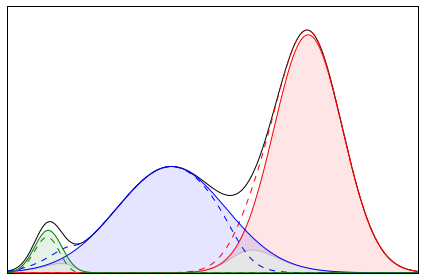

In [7]:
blending_plot(alpha=1.0,save='output/blending1d.pdf')